In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
data = pd.read_csv("Netflix_movies_and_tv_shows_clustering.csv", header=None)
data.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(7788, 12)

In [3]:
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11
0,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
2,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
3,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
4,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."


In [4]:
data.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9,10,11
count,7788,7788,7788,5399,7070,7281,7778,7788,7781,7788,7788,7788
unique,7788,3,7788,4050,6832,682,1566,74,15,217,493,7770
top,show_id,Movie,title,"Raúl Campos, Jan Suter",David Attenborough,United States,"January 1, 2020",2018,TV-MA,1 Season,Documentaries,Multiple women report their husbands as missin...
freq,1,5377,1,18,18,2555,118,1121,2863,1608,334,3


In [5]:
data[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0          type
1       TV Show
2         Movie
3         Movie
4         Movie
         ...   
7783      Movie
7784      Movie
7785      Movie
7786    TV Show
7787      Movie
Name: 1, Length: 7788, dtype: object

DATA VISUALIZATIONS

- The most demanded items in dataset / Top05

In [6]:
# 1. Gather All Items of Each Transactions into Numpy Array
transaction = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        transaction.append(data.values[i,j])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df = pd.DataFrame(transaction, columns=["items"])
df["incident_count"] = 1 # Put 1 to Each Item For Making Countable Table, to be able to perform Group By

# 3. Delete NaN Items from Dataset
indexNames = df[df['items'] == "nan" ].index
df.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations
df_table = df.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()

# 5. Initial Visualizations
df_table.head(10).style.background_gradient(cmap='Blues')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,items,incident_count
0,Movie,5377
1,TV-MA,2863
2,United States,2555
3,TV Show,2410
4,TV-14,1931
5,1 Season,1608
6,2018,1121
7,2017,1012
8,2019,996
9,India,923


- The most demanded items in dataset / Top20

In [7]:
df_table["all"] = "all" # to have a same origin

fig = px.treemap(df_table.head(20), path=['all', "items"], values='incident_count',
                  color=df_table["incident_count"].head(20), hover_data=['items'],
                  color_continuous_scale='Blues',
                  )
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Lets check whether the items have multiple records in a transaction or not
- If the answer is "Yes", we need to handle them since they might mislead the apriori algorithm in further steps

In [8]:
# Transform Every Transaction to Seperate List & Gather Them into Numpy Array
# By Doing So, We Will Be Able To Iterate Through Array of Transactions
transaction = []
for i in range(data.shape[0]):
    transaction.append([str(data.values[i,j]) for j in range(data.shape[1])])

transaction = np.array(transaction)

# Create a DataFrame In Order To Check Status of Top15 Items

top15 = df_table["items"].head(15).values
array = []
df_top15_multiple_record_check = pd.DataFrame(columns=top15)

for i in range(0, len(top15)):
    array = []
    for j in range(0,transaction.shape[0]):
        array.append(np.count_nonzero(transaction[j]==top15[i]))
        if len(array) == len(data):
            df_top15_multiple_record_check[top15[i]] = array
        else:
            continue


df_top15_multiple_record_check.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Movie,TV-MA,United States,TV Show,TV-14,1 Season,2018,2017,2019,India,2016,2020,TV-PG,R,2015
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0
7,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
8,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
9,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0


In [9]:
df_top15_multiple_record_check.describe()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Movie,TV-MA,United States,TV Show,TV-14,1 Season,2018,2017,2019,India,2016,2020,TV-PG,R,2015
count,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000,7788.000000
mean,0.690421,0.367617,0.328069,0.309450,0.247946,0.206471,0.143939,0.129944,0.127889,0.118516,0.113251,0.111454,0.103493,0.085388,0.069466
std,0.462350,0.482187,0.469540,0.462297,0.431848,0.404799,0.351051,0.336263,0.333988,0.323238,0.316920,0.314713,0.304621,0.279476,0.254261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Choice Analysis / Viewers' First Choices



In [10]:
# 1. Gather Only First Choice of Each Transactions into Numpy Array
# Similar Pattern to Above, Only Change is the Column Number "0" in Append Function
transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,0])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df_first = pd.DataFrame(transaction, columns=["items"])
df_first["incident_count"] = 1

# 3. Delete NaN Items from Dataset
indexNames = df_first[df_first['items'] == "nan" ].index
df_first.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations
df_table_first = df_first.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_first["tvshow"] = "tvshow"
df_table_first = df_table_first.truncate(before=-1, after=10) # Fist 10 Choice

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [11]:
fig = go.Figure(data=[go.Bar(x=df_table_first["items"], y=df_table_first["incident_count"],
            hovertext=df_table_first["items"], text=df_table_first["incident_count"], textposition="outside")])

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.65)
fig.update_layout(title_text="Customers' First Choices", template="plotly_dark")
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



- Choice Analysis / Viewers' Second Choices

In [13]:
# 1. Gather Only Second Choice of Each Transaction into Numpy Array
transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,1])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df_second = pd.DataFrame(transaction, columns=["items"])
df_second["incident_count"] = 1

# 3. Delete NaN Items from Dataset
indexNames = df_second[df_second['items'] == "nan" ].index
df_second.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations
df_table_second = df_second.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_second["tvshow"] = "tvshow"
df_table_second = df_table_second.truncate(before=-1, after=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



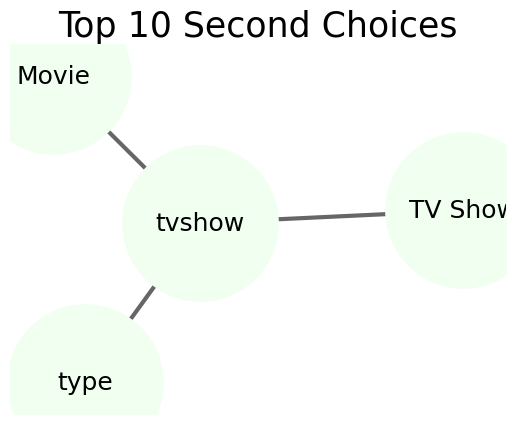

In [14]:
import warnings
warnings.filterwarnings('ignore')

second_choice = nx.from_pandas_edgelist(df_table_second, source = 'tvshow', target = "items", edge_attr = True)
pos = nx.spring_layout(second_choice)
nx.draw_networkx_nodes(second_choice, pos, node_size = 12500, node_color = "honeydew")
nx.draw_networkx_edges(second_choice, pos, width = 3, alpha = 0.6, edge_color = 'black')
nx.draw_networkx_labels(second_choice, pos, font_size = 18, font_family = 'sans-serif')
plt.rcParams['figure.figsize'] = (20, 20)
plt.axis('off')
plt.grid()
plt.title('Top 10 Second Choices', fontsize = 25)
plt.show()

In [15]:
fig = go.Figure(data=[go.Bar(x=df_table_second["items"], y=df_table_second["incident_count"],
            hovertext=df_table_second["items"], text=df_table_second["incident_count"], textposition="outside")])

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.65)
fig.update_layout(title_text="Customers' Second Choices", template="plotly_dark")
fig.show()

In [16]:
transaction = []
for i in range(0, data.shape[0]):
    transaction.append(data.values[i,2])

transaction = np.array(transaction)

# 2. Transform Them a Pandas DataFrame
df_third = pd.DataFrame(transaction, columns=["items"]) # Transaction Item Name
df_third["incident_count"] = 1 # Put 1 to Each Item For Making Countable Table, Group By Will Be Done Later On

# 3. Delete NaN Items from Dataset
indexNames = df_third[df_third['items'] == "nan" ].index
df_third.drop(indexNames , inplace=True)

# 4. Final Step: Make a New Appropriate Pandas DataFrame for Visualizations
df_table_third = df_third.groupby("items").sum().sort_values("incident_count", ascending=False).reset_index()
df_table_third["tvshow"] = "tvshow"
df_table_third = df_table_third.truncate(before=-1, after=10)

In [17]:
fig = go.Figure(data=[go.Bar(x=df_table_third["items"], y=df_table_third["incident_count"],
            hovertext=df_table_third["items"], text=df_table_third["incident_count"], textposition="outside")])

fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.65)
fig.update_layout(title_text="Customers' Third Choices", template="plotly_dark")
fig.show()

In [18]:
# Transform Every Transaction to Seperate List & Gather Them into Numpy Array
transaction = []
for i in range(data.shape[0]):
    transaction.append([str(data.values[i,j]) for j in range(data.shape[1])])

transaction = np.array(transaction)
transaction

array([['show_id', 'type', 'title', ..., 'duration', 'listed_in',
        'description'],
       ['s1', 'TV Show', '3%', ..., '4 Seasons',
        'International TV Shows, TV Dramas, TV Sci-Fi & Fantasy',
        'In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor.'],
       ['s2', 'Movie', '7:19', ..., '93 min',
        'Dramas, International Movies',
        'After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive.'],
       ...,
       ['s7785', 'Movie', 'Zulu Man in Japan', ..., '44 min',
        'Documentaries, International Movies, Music & Musicals',
        "In this documentary, South African rapper Nasty C hits the stage and streets of Tokyo, introducing himself to the city's sights, sounds and culture."],
       ['s7786', 'TV Show', "Zumbo's Just Desserts", ..., '1 Season',
        'International TV Sho

In [19]:
te = TransactionEncoder()
te_ary = te.fit(transaction).transform(transaction)
dataset = pd.DataFrame(te_ary, columns=te.columns_)
dataset

,"April 15, 2018","April 16, 2019","April 17, 2016","April 20, 2017","April 4, 2017","August 1, 2017","August 13, 2018","August 21, 2017","August 4, 2017","December 1, 2018",...,​Goli Soda 2,​Maj Rati ​​Keteki,​Mayurakshi,​SAINT SEIYA: Knights of the Zodiac,​​Kuch Bheege Alfaaz,忍者ハットリくん,海的儿子,마녀사냥,반드시 잡는다,최강전사 미니특공대 : 영웅의 탄생
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7784,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7785,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7786,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
dataset.shape

(7788, 37224)

In [21]:
first50 = df_table["items"].head(50).values # Select Top50
dataset = dataset.loc[:,first50] # Extract Top50
dataset

,Movie,TV-MA,United States,TV Show,TV-14,1 Season,2018,2017,2019,India,...,"Comedies, International Movies","Dramas, International Movies, Romantic Movies","Comedies, International Movies, Romantic Movies",2009,90 min,Spain,93 min,2008,91 min,94 min
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7783,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7784,True,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
7785,True,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7786,False,False,False,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
dataset.columns

Index(['Movie', 'TV-MA', 'United States', 'TV Show', 'TV-14', '1 Season',
       '2018', '2017', '2019', 'India', '2016', '2020', 'TV-PG', 'R', '2015',
       'United Kingdom', 'PG-13', '2 Seasons', '2014', 'Documentaries',
       'Stand-Up Comedy', 'Dramas, International Movies', 'TV-Y', 'TV-Y7',
       '2013', 'PG', 'Comedies, Dramas, International Movies', 'Japan', '2012',
       'Dramas, Independent Movies, International Movies', 'Kids' TV', 'TV-G',
       '3 Seasons', 'South Korea', 'Children & Family Movies', 'Canada',
       '2010', 'Documentaries, International Movies',
       'Children & Family Movies, Comedies', '2011',
       'Comedies, International Movies',
       'Dramas, International Movies, Romantic Movies',
       'Comedies, International Movies, Romantic Movies', '2009', '90 min',
       'Spain', '93 min', '2008', '91 min', '94 min'],
      dtype='object')

In [23]:
# Convert dataset into 1-0 encoding
def encode_units(x):
    if x == False:
        return 0
    if x == True:
        return 1

dataset = dataset.applymap(encode_units)
dataset.head(10)

,Movie,TV-MA,United States,TV Show,TV-14,1 Season,2018,2017,2019,India,...,"Comedies, International Movies","Dramas, International Movies, Romantic Movies","Comedies, International Movies, Romantic Movies",2009,90 min,Spain,93 min,2008,91 min,94 min
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


Main Concepts of association rules/Apriori Algorithm

In [24]:
# Extracting the most frequest itemsets via Mlxtend.
# The length column has been added to increase ease of filtering.
frequent_itemsets = apriori(dataset, min_support=0.01, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets


,support,itemsets,length
0,0.690421,(Movie),1
1,0.367617,(TV-MA),1
2,0.328069,(United States),1
3,0.309450,(TV Show),1
4,0.247946,(TV-14),1
...,...,...,...
299,0.017976,"(2018, TV Show, TV-MA, 1 Season)",4
300,0.018747,"(2019, TV Show, TV-MA, 1 Season)",4
301,0.022599,"(TV Show, TV-MA, 2020, 1 Season)",4
302,0.010401,"(TV-14, TV Show, 1 Season, United States)",4


We can easily explore the itemsets via below snippes

In [25]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.05) ]

,support,itemsets,length
50,0.236903,"(Movie, TV-MA)",2
51,0.237545,"(Movie, United States)",2
52,0.163328,"(Movie, TV-14)",2
53,0.094248,"(Movie, 2018)",2
54,0.095532,"(Movie, 2017)",2
55,0.074730,"(Movie, 2019)",2
56,0.109399,"(Movie, India)",2
57,0.082435,"(Movie, 2016)",2
58,0.052773,"(Movie, 2020)",2
59,0.064843,"(Movie, TV-PG)",2


In [26]:
frequent_itemsets[ (frequent_itemsets['length'] == 3) ].head()

,support,itemsets,length
195,0.074859,"(Movie, TV-MA, United States)",3
196,0.044684,"(Movie, 2018, TV-MA)",3
197,0.043143,"(Movie, 2017, TV-MA)",3
198,0.034797,"(Movie, TV-MA, 2019)",3
199,0.025809,"(Movie, India, TV-MA)",3


In [27]:
frequent_itemsets[ (frequent_itemsets['length'] == 4) ].head()

,support,itemsets,length
291,0.013867,"(Movie, 2018, TV-MA, United States)",4
292,0.017206,"(Movie, 2017, TV-MA, United States)",4
293,0.013354,"(Movie, 2019, TV-MA, United States)",4
294,0.010914,"(Movie, 2016, TV-MA, United States)",4
295,0.021700,"(Movie, Stand-Up Comedy, TV-MA, United States)",4


In [28]:
frequent_itemsets[ (frequent_itemsets['length'] == 5) ].head()

,support,itemsets,length


In [29]:
# We can create our rules by defining metric and its threshold.

# For a start,
#      We set our metric as "Lift" to define whether antecedents & consequents are dependent our not.
#      Treshold is selected as "1.2" since it is required to have lift scores above than 1 if there is dependency.

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
479,(Kids' TV),"(TV Show, TV-Y)",0.026323,0.020930,0.014124,0.536585,25.637588,0.013573,2.112731,0.986974,1,2
478,"(TV Show, TV-Y)",(Kids' TV),0.020930,0.026323,0.014124,0.674847,25.637588,0.013573,2.994517,0.981538,2,1
484,"(TV Show, TV-Y7)",(Kids' TV),0.022599,0.026323,0.010272,0.454545,17.268293,0.009677,1.785075,0.963873,2,1
485,(Kids' TV),"(TV Show, TV-Y7)",0.026323,0.022599,0.010272,0.390244,17.268293,0.009677,1.602938,0.967559,1,2
138,(PG),"(Children & Family Movies, Comedies)",0.031715,0.021700,0.011043,0.348178,16.045037,0.010354,1.500870,0.968388,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
399,(2020),"(TV-14, TV Show)",0.111454,0.084617,0.011428,0.102535,1.211744,0.001997,1.019964,0.196662,1,2
76,(TV Show),(TV-PG),0.309450,0.103493,0.038649,0.124896,1.206814,0.006623,1.024458,0.248167,1,1
77,(TV-PG),(TV Show),0.103493,0.309450,0.038649,0.373449,1.206814,0.006623,1.102144,0.191155,1,1
249,(2017),"(Movie, TV-PG)",0.129944,0.064843,0.010144,0.078063,1.203874,0.001718,1.014339,0.194641,1,2


According to above table, we can easily say that the dependency between (herb & pepper) and (ground beef) is high since lift score is approximately 2.5x of threshold and the confidence score is promising (32%)

In order to get more insights from the data, let’s look into confidence!

In [30]:
# Sort values based on confidence
rules.sort_values("confidence",ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedents_length,consequents_length
472,"(2020, 2 Seasons)",(TV Show),0.010015,0.309450,0.010015,1.000000,3.231535,0.006916,inf,0.697536,2,1
442,"(1 Season, TV-Y)",(TV Show),0.011299,0.309450,0.011299,1.000000,3.231535,0.007803,inf,0.698442,2,1
155,"(Documentaries, TV-MA)",(Movie),0.013482,0.690421,0.013482,1.000000,1.448391,0.004174,inf,0.313810,2,1
448,"(1 Season, TV-Y7)",(TV Show),0.010272,0.309450,0.010272,1.000000,3.231535,0.007093,inf,0.697717,2,1
586,"(2019, TV-MA, 1 Season)",(TV Show),0.018747,0.309450,0.018747,1.000000,3.231535,0.012946,inf,0.703742,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
245,(Movie),"(2018, India)",0.690421,0.012198,0.010529,0.015250,1.250190,0.002107,1.003099,0.646433,1,2
213,(Movie),"(Children & Family Movies, Comedies, United St...",0.690421,0.010401,0.010401,0.015064,1.448391,0.003220,1.004735,1.000000,1,2
282,(Movie),"(2016, R)",0.690421,0.010272,0.010144,0.014692,1.430286,0.003052,1.004486,0.971770,1,2
241,(Movie),"(TV-14, Dramas, International Movies, Romantic...",0.690421,0.010015,0.010015,0.014506,1.448391,0.003101,1.004557,1.000000,1,2


According to above table, the customers who watched (Mr Robot,the black list ground beef) is expected to watch (Ozark) with a likelihood of 50% (confidence). Lift & conviction scores support that hypothesis too
It would be better to keep them close to increase sales !
Since the most demanded product is mineral water in the dataset, the association results are mainly dominated by it. From that reason, to get more insights, it’s better to create a confidence table excluding the mineral water